**This is a work in progress.** 

## Problem summary:
Recordings from accelerometers strapped to a participant's chest are to be used to determine the activity the participant is performing, using labeled data. The sensors record at 52Hz. 

The data set is not large, and can be opened in memory easily. 

For more information, see: http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#

---
## Approach:

A simple approach would be to extract frequency information about each activity using Fourier Transforms, and use those as features to a classifier like a decision tree.  

Alternatively, given the [unreasonable effectiveness of reccurent neural networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) it would be interesting to know whether a recurrent neural network would be able to abstract "frequency" from the *raw* data.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
# helper functions for describing data

def get_data_dir():
    return os.path.join(os.getcwd(), 'data/')

def csv_file_names():
    data_dir = os.path.join(os.getcwd(), 'data/')
    files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    return files

def get_file_names():
    return np.arange(1, 16)


def get_activities():
    activities = {
        1: "Working at Computer",
        2: "Standing Up, Walking and Going updown stairs",
        3: "Standing",
        4: "Walking",
        5: "Going UpDown Stairs",
        6: "Walking and Talking with Someone",
        7: "Talking while Standin",        
    }
    return activities

# Load data set for exploration

In [5]:
def load_raw_data():

    data_dir = os.path.join(os.getcwd(), 'data/')
    file_names = get_file_names()    
    
    column_labels = ["index", "x_accel", "y_accel", "z_accel", "activity"]
    
    # store the data as dataframes in a dictionary,
    # which makes it easier to later separate dataset
    # into training, validation, and testing subsets
    dataset = {}
    for file_name in file_names:
        df = pd.read_csv(data_dir + str(file_name) + ".csv", names = column_labels)
        dataset[file_name] = df
        
    return dataset

In [ ]:
data_lib = load_raw_data()

# Visualize distribution of data per activity and per file

file # 1


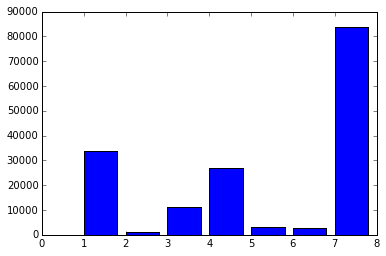

file # 2


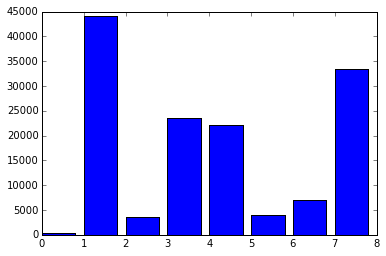

file # 3


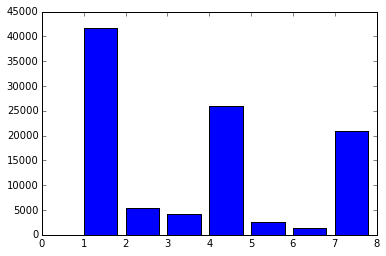

file # 4


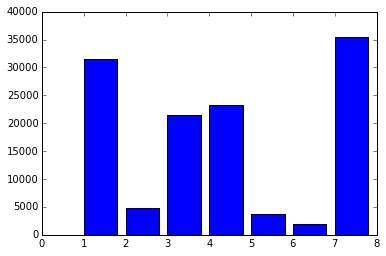

file # 5


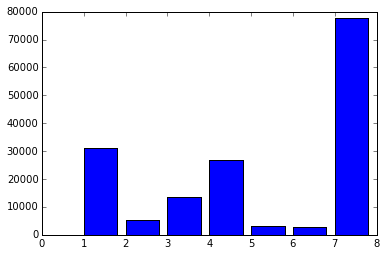

file # 6


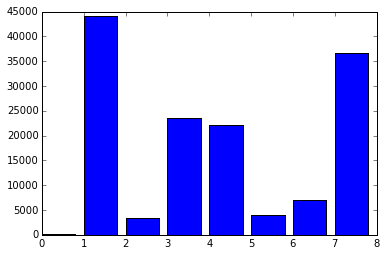

file # 7


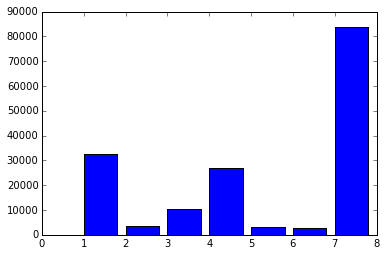

file # 8


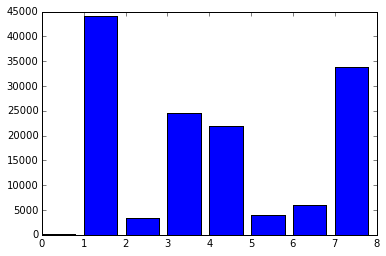

file # 9


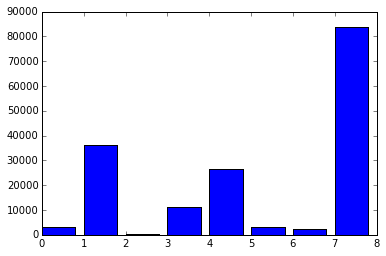

file # 10


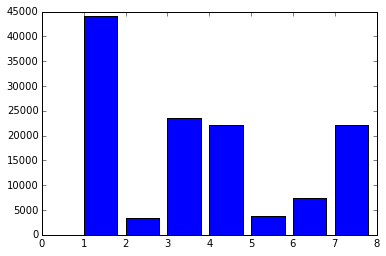

file # 11


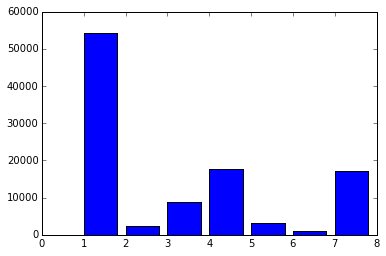

file # 12


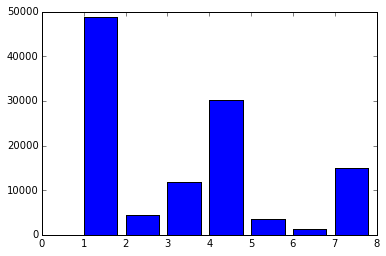

file # 13


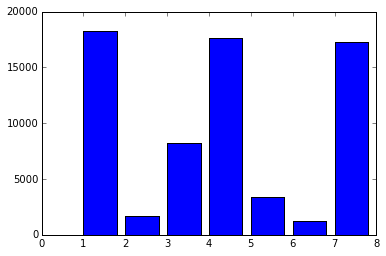

file # 14


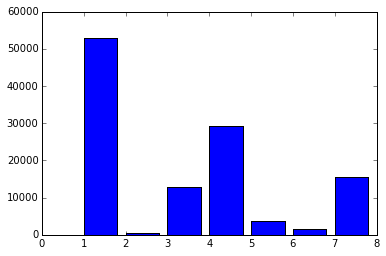

file # 15


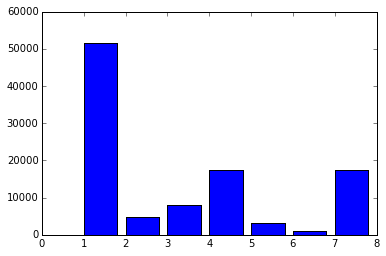

In [7]:
for file_name, df in data_lib.items():
    print("file #", file_name)
    activity_histogram = df.groupby('activity').size()
    plt.bar(activity_histogram.index, activity_histogram.values)
    plt.show()

# Conclusions about data distribution:
**Note #1**: We have unbalanced classes. Some activities are represented over 100x more than others. Therefore, our sampling method should enforce equal representation of activities in order to prevent our model from being biased towards activities that are simply more frequent. 

**Note #2**: There is one more distinct activity than expected (8 instead of the 7 described in the problem website). Further investigation shows some rows have 0 in the activity column. 

# Visualize raw data

/Applications/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


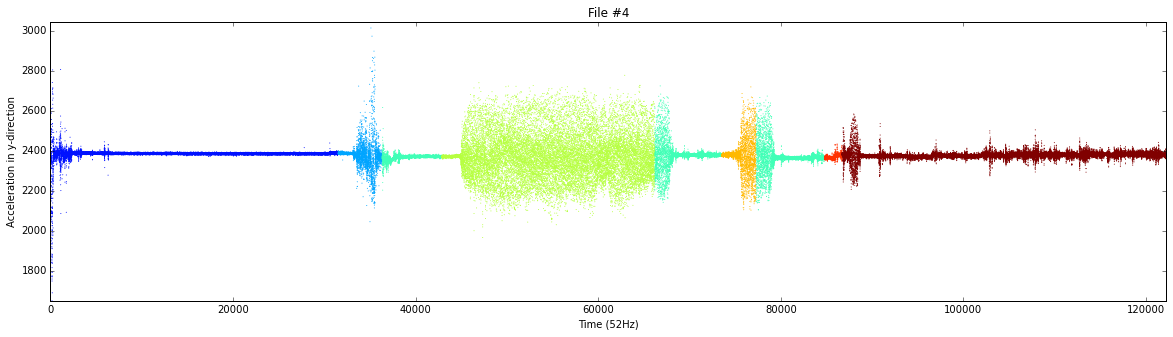

In [32]:
example_file_num = 4
example = data_lib[example_file_num]
x = example.index
y = example.y_accel # (x_accel and z_accel values are very similar, so they're not shown here)

# set plot size and options
fig, ax = plt.subplots(figsize=(20,5))

# labels
ax.set_title("File #" + str(example_file_num))
ax.set_xlabel('Time (52Hz)')
ax.set_ylabel('Acceleration in y-direction')

# center the plot
ax.set_ylim(y.min(), y.max())
ax.set_xlim(0, len(x))

ax.scatter(x, y, c=example.activity, edgecolor='', s=1)

# Observations from example:
0. There are large apprent "lulls" around each activity.  
1. Fourier transforms are almost certainly a good idea.
2. Variance could be a feature for a learning algorithm
3. Data range in the thousands means normalization will be useful in most cases and necessary with neural networks
0. It is unclear whether spikes are noise or signal. Spikes may correspond to transition between activities, and not truly belong in the training set. Removing outliers may be necessary.

# Plot fourier transform of activities in example file

In [26]:
# we don't care about the phase (imaginary part of the transform)
# so just get the absolute value: sqrt(a^2 + b^2) where a + bi is the FFT value
# this will be the amplitude for various frequencies
def abs_rfft( series ):
    complex_fourier = np.fft.rfft( series )
    return np.absolute(complex_fourier)

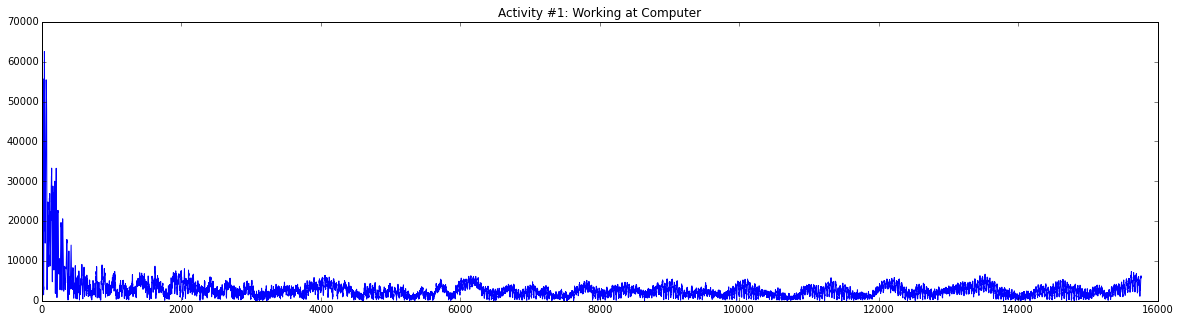

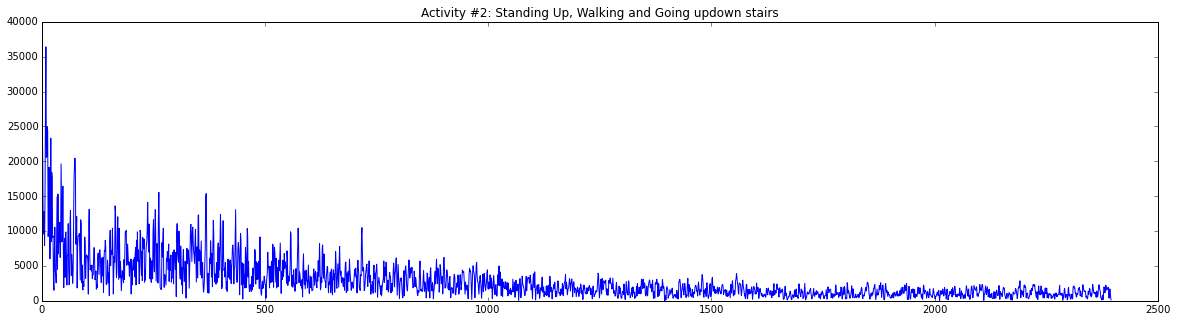

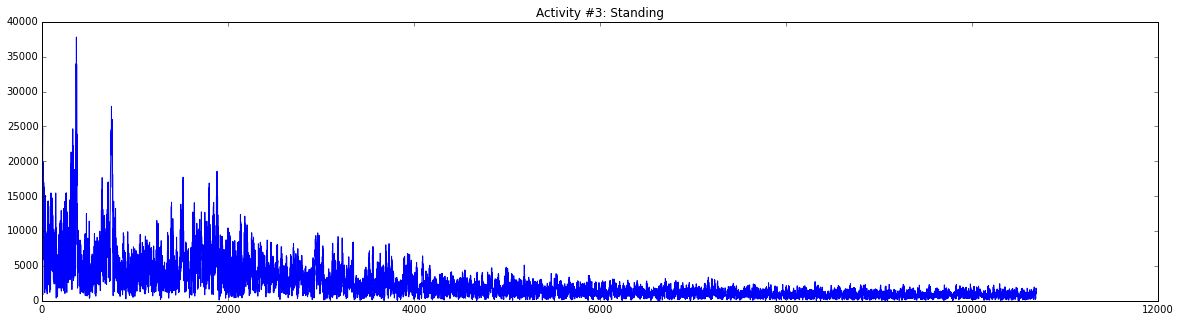

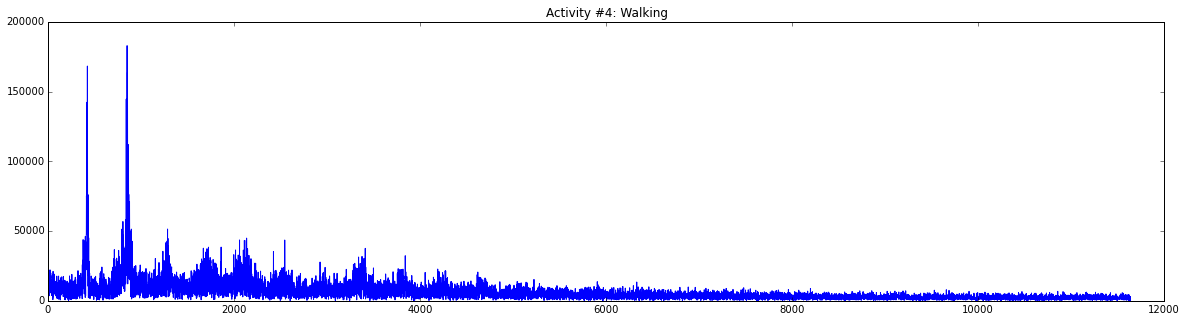

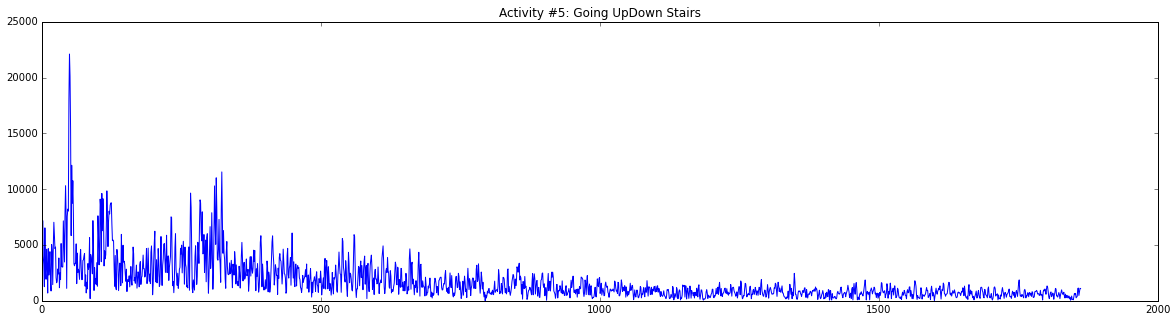

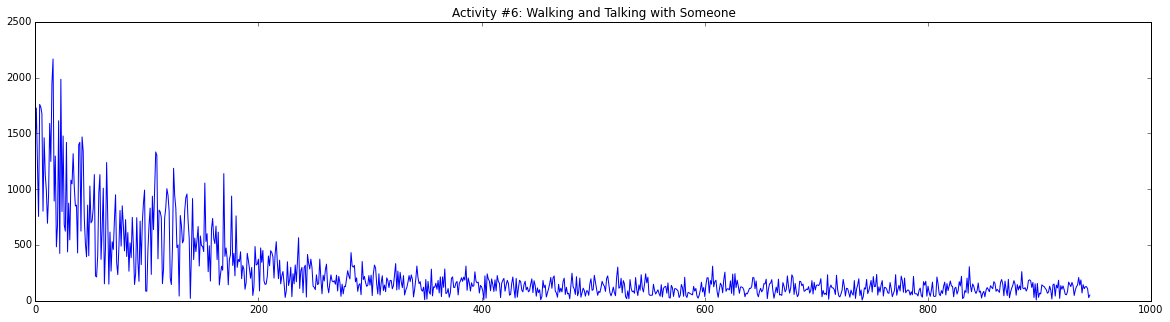

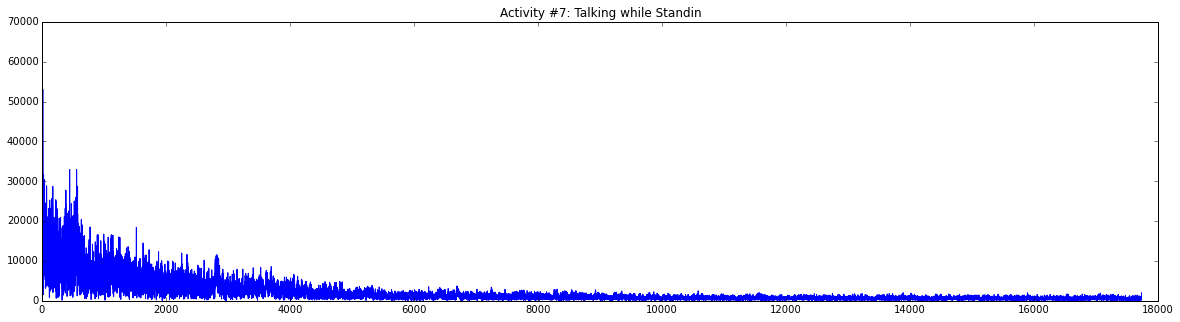

In [27]:
# produce plots for fourier transforms of each activity in sample file
activities = get_activities()
for activity_num, label in activities.items():
    example_filtered = example[example.activity == activity_num]
    ex_fft = abs_rfft( example_filtered.x_accel)
    fig, f_ax = plt.subplots(figsize=(20,5))
    f_ax.set_title(label='Activity #' + str(activity_num) + ': ' + str(label))
    f_ax.plot(ex_fft[10:]) # near-zero frequencies have enormous amplitude (millions). Skipping in plot.

# Notable things about plots of fourier transforms of activities:
0. The frequencies with highest amplitudes (perhaps the top 3-5), can be a feature
1. We have to be sensible about what range of frequencies to use as features. 
2. It would be interesting to look at shorter sequences for each activity, and perhaps across files. Frequency ranges should be similar at time-scale of few seconds.
3. A few (~10) extreme amplitudes (~1000x above mean) pop up for near-zero frequencies. These are likely to be noise.

# Randomly select training, validation, and test files

In [34]:
# of the 15 files given, select n at random for training and m for validation
def split_dataset(train_size = 10, valid_size = 1):

    filenames = get_file_names()
    
    # raise error if requested sets exceed available num of sets
    if train_size + valid_size >= len(filenames):
        raise ValueError("No room for test files. Total should be less than", len(filenames))
    
    # shuffle file names
    np.random.shuffle(filenames)
    
    train_filenames = filenames[0:train_size]
    valid_filenames = filenames[train_size: train_size+valid_size]
    test_filenames = filenames[train_size+valid_size::]
    
    return train_filenames, valid_filenames, test_filenames

In [43]:
"""
Returns a single sample of contiguous rows from one of the raw data files.
Optionally, you can restrict sampling to subset of files,
and to a particular activity.
The length of the sample defaults to 520, which corresponds to 10 seconds of activity,
but can be set as an argument sample_length.

This functions samples equally from all activities if no activity is defined,
which is ideal for training, because in the raw data, different activities
are represented unequally
"""

def get_sample(allowed_files=get_file_names(), act_num=None, sample_length = 520):
    
    file_name = np.random.choice(allowed_files)
    
    file_data = data_lib[file_name]
    
    # We specify activity in order to 
    # a) avoid sampling rows spanning multiple activities, and
    # b) give equal opportunity to each activity regardless of its relative representation in the dataset
    if act_num is None:
        act_num = np.random.choice(range(1,8))
        
    # filter data to activity specified
    activity_data = file_data[file_data.activity == act_num]
    
    # take a horizontal slice of the activity data of given length
    array_length = len(activity_data)
    
    if array_length <= sample_length:
        # zero pad?
        return
    else:
        start_index = np.random.choice(range(0, array_length - sample_length), 1)
        end_index = start_index + sample_length
        sample = activity_data[start_index:end_index]
    
    sample_inputs = sample[['x_accel', 'y_accel', 'z_accel' ]].as_matrix()
    sample_target = act_num
    
    return sample_inputs, sample_target

In [44]:
def build_sample_set(file_names=None, num_samples=100, sample_length=520, fourier_transform=False):
    # to do: balance classes
    sample_set = list()
    sampled = 0
    while sampled < num_samples:
        new_sample = get_sample(file_names, sample_length=sample_length)
        if fourier_transform == True:
            new_sample = abs_rfft(new_sample)
        sample_set.append(new_sample)
        sampled += 1
    
    return sample_set

In [45]:
training_file_names, validation_file_names, test_file_names = split_dataset(10, 2)

train_set = build_sample_set(training_file_names, num_samples=7000)
validation_set = build_sample_set(validation_file_names, num_samples = 100)
test_set = build_sample_set(test_file_names, num_samples = 777)

In [59]:
"""
Let's pickle (save to disk) the generated training, validation, and test sets.
These are expensive to generate on the fly, 
particularly if we normalize or apply Fourier Transforms down the line
"""
train = open('train_set', 'wb')
pickle.dump(train_set, train)

valid = open('validation_set', 'wb')
pickle.dump(validation_set, valid)

test = open('testing_set', 'wb')
pickle.dump(test_set, test)

In [63]:
# Let's explore the 10 second snapshot of a random activity
X_train, Y_train = get_sample()

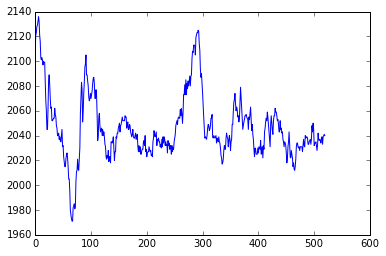

In [41]:
plt.plot(X_train.x_accel.values)

In [42]:
sample_fourier = abs_rfft(X_train.x_accel)

In [33]:
plt.plot(sample_fourier[10::])

NameError: name 'sample_fourier' is not defined